In [2]:
import pandas as pd

In [122]:
df = pd.read_csv('/home/pratyush/Desktop/Temenos/Ours/averaged_scores_sector_with_beta.csv')

In [125]:
df

,Unnamed: 0,Company_Symbol,Total-Score,E-Score,S-Score,G-Score,SECTOR,INDUSTRY,beta
0,0,AAPL,15.064636,0.559196,5.947646,8.498634,Information Technology,Technology Hardware Storage & Peripherals,1.240
1,1,ABBV,27.458170,2.146419,16.417683,8.131236,Health Care,Biotechnology,0.613
2,2,ABT,21.218078,1.721684,13.293709,6.225313,Health Care,Health Care Equipment,0.722
3,3,ACGL,19.435768,1.389658,8.872647,8.655150,Financials,Property & Casualty Insurance,0.613
4,4,ACN,10.379454,1.754841,5.788745,2.943354,Information Technology,IT Consulting & Other Services,1.245
...,...,...,...,...,...,...,...,...,...
409,418,XOM,44.360811,25.747124,11.569692,7.270506,Energy,Integrated Oil & Gas,0.880
410,419,XYL,21.840131,9.343422,7.503116,4.436266,Industrials,Industrial Machinery & Supplies & Components,1.050
411,420,YUM,21.131232,6.744679,10.872904,3.390394,Consumer Discretionary,Restaurants,1.095
412,421,ZBH,24.292029,4.738192,12.762260,6.696869,Health Care,Health Care Equipment,1.021


In [121]:
df.to_csv('averaged_scores_sector_with_beta.csv',index=False)

# Custom ESG Portfolio Optimization

In [12]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple


#### ESG score is used here as the "return"
#### Beta is risk


## Maximize the total ESG score of the portfolio

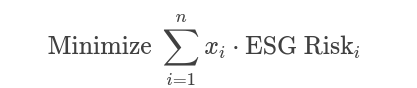

#### Ensures the total allocation does not exceed the user's budget.

## Budget Constraint 

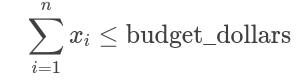

#### Ensures the portfolio's weighted average beta does not exceed the user's risk tolerance.

## Risk Constraint - 

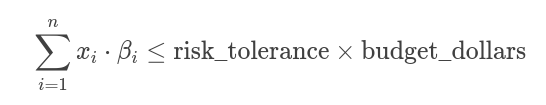

Ensures exactly max_companies (e.g., 10) are included in the portfolio.

In [103]:
# Inputs
budget_dollars = 10000  # User-provided budget in dollars
risk_tolerance = 0.7  # Maximum portfolio beta
max_companies = 10  # Maximum number of companies to invest in
min_value = 0.01  # At least 1% of the budget is allocated to each stock

problem = pulp.LpProblem("Minimize_Total_Score", pulp.LpMinimize)

companies = df['Company_Symbol']
x = pulp.LpVariable.dicts("Allocation", companies, lowBound=0, upBound=budget_dollars)  
y = pulp.LpVariable.dicts("Include", companies, cat="Binary") 

# Objective function: Minimize Total Score (ESG Risk)
problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0] for company in companies]), "Total_Score"

# Constraints
# 1. Budget constraint: Sum of allocations <= budget_dollars
problem += pulp.lpSum([x[company] for company in companies]) == budget_dollars, "Budget_Constraint"

# 2. Risk constraint: Sum of (allocation * beta) <= risk_tolerance * budget_dollars
problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'beta'].values[0] for company in companies]) <= risk_tolerance * budget_dollars, "Risk_Constraint"

# 3. Cardinality constraint: Invest in exactly `max_companies` companies
problem += pulp.lpSum([y[company] for company in companies]) == max_companies, "Cardinality_Constraint"

for company in companies:
    problem += x[company] <= y[company] * budget_dollars, f"Linking_{company}"

# 5. Minimum allocation constraint: Ensure each selected company gets at least a small allocation
min_allocation = min_value * budget_dollars  # At least 1% of the budget
for company in companies:
    problem += x[company] >= y[company] * min_allocation, f"Min_Allocation_{company}"

problem.solve()

print("Status:", pulp.LpStatus[problem.status])
print("Optimal Allocations:")
for company in companies:
    if x[company].varValue > 0:
        print(f"{company}: ${x[company].varValue:.2f}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pratyush/miniconda3/envs/temenos/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a0853528bd77465295df7c7c9a0a8b85-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/a0853528bd77465295df7c7c9a0a8b85-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 836 COLUMNS
At line 4977 RHS
At line 5809 BOUNDS
At line 6638 ENDATA
Problem MODEL has 831 rows, 828 columns and 2898 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 59777.1 - 0.01 seconds
Cgl0004I processed model has 831 rows, 828 columns (414 integer (414 of which binary)) and 2898 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 3.33067e-16
Cbc0038I Solution found of 59777.1
Cbc0038I Relaxing continuous gives 59777.1
Cbc0038I Before mini branch and bound, 414 integers at bound fixed and 40

## Sector Diversification 

In [141]:
budget_dollars = 10000  # User-provided budget in dollars
risk_tolerance = 1.2  # Maximum portfolio beta
max_companies = 5  # Maximum number of companies to invest in
min_value = 0.01  # At least 1% of the budget is allocated to each stock
min_sectors = 3  # Minimum number of sectors to include in the portfolio

def sector_diversification(budget_dollars, risk_tolerance, max_companies, min_value, min_sectors):

    problem = pulp.LpProblem("Minimize_Total_Score_Sector_Diversification", pulp.LpMinimize)


    companies = df['Company_Symbol']
    x = pulp.LpVariable.dicts("Allocation", companies, lowBound=0, upBound=budget_dollars)  
    y = pulp.LpVariable.dicts("Include", companies, cat="Binary") 


    sectors = df['SECTOR'].unique()
    sector_included = pulp.LpVariable.dicts("Sector_Included", sectors, cat="Binary")  # Binary variable: 1 if sector is included, 0 otherwise

    # Objective function: Minimize Total Score (ESG Risk)
    problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0] for company in companies]), "Total_Score"

    # Constraints
    # 1. Budget constraint: Sum of allocations <= budget_dollars
    problem += pulp.lpSum([x[company] for company in companies]) == budget_dollars, "Budget_Constraint"

    # 2. Risk constraint: Sum of (allocation * beta) <= risk_tolerance * budget_dollars
    problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'beta'].values[0] for company in companies]) <= risk_tolerance * budget_dollars, "Risk_Constraint"

    # 3. Cardinality constraint: Invest in exactly `max_companies` companies
    problem += pulp.lpSum([y[company] for company in companies]) == max_companies, "Cardinality_Constraint"

    # 4. Linking constraint: Allocation can only be non-zero if the company is included
    for company in companies:
        problem += x[company] <= y[company] * budget_dollars, f"Linking_{company}"

    # 5. Minimum allocation constraint: Ensure each selected company gets at least a small allocation
    min_allocation = min_value * budget_dollars  # At least 1% of the budget
    for company in companies:
        problem += x[company] >= y[company] * min_allocation, f"Min_Allocation_{company}"

    # 6. Sector diversification constraint: Include at least `min_sectors` sectors
    problem += pulp.lpSum([sector_included[sector] for sector in sectors]) >= min_sectors, "Sector_Diversification_Constraint"
    
    for company in companies:
        sector = df.loc[df['Company_Symbol'] == company, 'SECTOR'].values[0]
        problem += y[company] <= sector_included[sector], f"Sector_Link_{company}"

    problem.solve()

    portfolio = {}

    for company in companies:
        if y[company].varValue == 1:  
            allocation = x[company].varValue
            portfolio[company] = round(allocation, 2)

    included_sectors = [sector for sector in sectors if sector_included[sector].varValue == 1]
    
    print(f"Status: {pulp.LpStatus[problem.status]}")
    print(f"Optimal Allocations (Total ESG Score Minimization):")
    for company, allocation in portfolio.items():
        print(f"{company}: ${allocation:.2f} (Total Score: {df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0]}, Sector: {df.loc[df['Company_Symbol'] == company, 'SECTOR'].values[0]})")
    
    print(f"Included Sectors: {included_sectors}")
    
    return portfolio

sector_diversification(budget_dollars, risk_tolerance, max_companies, min_value, min_sectors)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pratyush/miniconda3/envs/temenos/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/6da1eef2c6bd42629ba6ee042f7eba1d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/6da1eef2c6bd42629ba6ee042f7eba1d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1251 COLUMNS
At line 6253 RHS
At line 7500 BOUNDS
At line 8340 ENDATA
Problem MODEL has 1246 rows, 839 columns and 3737 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 45901.8 - 0.00 seconds
Cgl0004I processed model has 831 rows, 828 columns (414 integer (414 of which binary)) and 2898 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 8.88178e-16
Cbc0038I Solution found of 45901.8
Cbc0038I Relaxing continuous gives 45901.8
Cbc0038I Before mini branch and bound, 414 integers at bound fixed and 

{'BWA': 100.0, 'CBRE': 100.0, 'CDW': 100.0, 'DHR': 9600.0, 'HAS': 100.0}

In [126]:

# Inputs
budget_dollars = 10000  # User-provided budget in dollars
risk_tolerance = 1.2  # Maximum portfolio beta
max_companies = 10  # Maximum number of companies to invest in
min_value = 0.01  # At least 1% of the budget is allocated to each stock
min_sectors = 3  # Minimum number of sectors to include in the portfolio


problem = pulp.LpProblem("Minimize_Total_Score_Sector_Diversification", pulp.LpMinimize)


companies = df['Company_Symbol']
x = pulp.LpVariable.dicts("Allocation", companies, lowBound=0, upBound=budget_dollars)
y = pulp.LpVariable.dicts("Include", companies, cat="Binary")  


sectors = df['SECTOR'].unique()
sector_included = pulp.LpVariable.dicts("Sector_Included", sectors, cat="Binary")  # Binary variable: 1 if sector is included, 0 otherwise

# Objective function: Minimize Total Score (ESG Risk)
problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0] for company in companies]), "Total_Score"

# Constraints
# 1. Budget constraint: Sum of allocations <= budget_dollars
problem += pulp.lpSum([x[company] for company in companies]) == budget_dollars, "Budget_Constraint"

# 2. Risk constraint: Sum of (allocation * beta) <= risk_tolerance * budget_dollars
problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'beta'].values[0] for company in companies]) <= risk_tolerance * budget_dollars, "Risk_Constraint"

# 3. Cardinality constraint: Invest in exactly `max_companies` companies
problem += pulp.lpSum([y[company] for company in companies]) == max_companies, "Cardinality_Constraint"

# 4. Linking constraint: Allocation can only be non-zero if the company is included
for company in companies:
    problem += x[company] <= y[company] * budget_dollars, f"Linking_{company}"

# 5. Minimum allocation constraint: Ensure each selected company gets at least a small allocation
min_allocation = min_value * budget_dollars  # At least 1% of the budget
for company in companies:
    problem += x[company] >= y[company] * min_allocation, f"Min_Allocation_{company}"

# 6. Sector diversification constraint: Include at least `min_sectors` sectors
problem += pulp.lpSum([sector_included[sector] for sector in sectors]) >= min_sectors, "Sector_Diversification_Constraint"


for company in companies:
    sector = df.loc[df['Company_Symbol'] == company, 'SECTOR'].values[0]
    problem += y[company] <= sector_included[sector], f"Sector_Link_{company}"


problem.solve()

print("Status:", pulp.LpStatus[problem.status])
print("Optimal Allocations:")
for company in companies:
    if y[company].varValue == 1:  # Only show included companies
        print(f"{company}: ${x[company].varValue:.2f} (Total Score: {df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0]}, Sector: {df.loc[df['Company_Symbol'] == company, 'SECTOR'].values[0]})")
included_sectors = [sector for sector in sectors if sector_included[sector].varValue == 1]
print(f"Included Sectors: {included_sectors}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pratyush/miniconda3/envs/temenos/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a90e17ab94a249b2ab5eb637ac5fcc23-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/a90e17ab94a249b2ab5eb637ac5fcc23-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1251 COLUMNS
At line 6253 RHS
At line 7500 BOUNDS
At line 8340 ENDATA
Problem MODEL has 1246 rows, 839 columns and 3737 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 47716.7 - 0.01 seconds
Cgl0004I processed model has 831 rows, 828 columns (414 integer (414 of which binary)) and 2898 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.66533e-15
Cbc0038I Solution found of 47716.7
Cbc0038I Relaxing continuous gives 47716.7
Cbc0038I Before mini branch and bound, 414 integers at bound fixed and 

## Industry Diversification

In [140]:
# Inputs
budget_dollars = 10000  # User-provided budget in dollars
risk_tolerance = 1.2  # Maximum portfolio beta
max_companies = 10  # Maximum number of companies to invest in
min_value = 0.01  # At least 1% of the budget is allocated to each stock
min_industries = 5  # Minimum number of industries to include in the portfolio

def industry_diversification(budget_dollars, risk_tolerance, max_companies, min_value, min_industries):

    problem = pulp.LpProblem("Minimize_Total_Score_Portfolio_Optimization", pulp.LpMinimize)

    companies = df['Company_Symbol']
    x = pulp.LpVariable.dicts("Allocation", companies, lowBound=0, upBound=budget_dollars)  
    y = pulp.LpVariable.dicts("Include", companies, cat="Binary")  

    # Objective function: Minimize Total ESG Score
    problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'Total-Score'].values[0] for company in companies]), "Total_Score"

    # Constraints
    # 1. Budget constraint: Sum of allocations <= budget_dollars
    problem += pulp.lpSum([x[company] for company in companies]) == budget_dollars, "Budget_Constraint"

    # 2. Risk constraint: Sum of (allocation * beta) <= risk_tolerance * budget_dollars
    problem += pulp.lpSum([x[company] * df.loc[df['Company_Symbol'] == company, 'beta'].values[0] for company in companies]) <= risk_tolerance * budget_dollars, "Risk_Constraint"

    # 3. Cardinality constraint: Invest in exactly `max_companies` companies
    problem += pulp.lpSum([y[company] for company in companies]) == max_companies, "Cardinality_Constraint"

    # 4. Linking constraint: Allocation can only be non-zero if the company is included
    for company in companies:
        problem += x[company] <= y[company] * budget_dollars, f"Linking_{company}"

    # 5. Minimum allocation constraint: Ensure each selected company gets at least a small allocation
    min_allocation = min_value * budget_dollars  # At least 1% of the budget
    for company in companies:
        problem += x[company] >= y[company] * min_allocation, f"Min_Allocation_{company}"

    
    problem.solve()

    portfolio = {}

    for company in companies:
        if y[company].varValue == 1: 
            allocation = x[company].varValue
            portfolio[company] = round(allocation, 2)

    return portfolio

industry_diversification(budget_dollars, risk_tolerance, max_companies, min_value, min_industries)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/pratyush/miniconda3/envs/temenos/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/49eca35f7bcb4f3ab2d6add7f79b9afd-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/49eca35f7bcb4f3ab2d6add7f79b9afd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 836 COLUMNS
At line 4977 RHS
At line 5809 BOUNDS
At line 6638 ENDATA
Problem MODEL has 831 rows, 828 columns and 2898 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 47716.7 - 0.00 seconds
Cgl0004I processed model has 831 rows, 828 columns (414 integer (414 of which binary)) and 2898 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 1.66533e-15
Cbc0038I Solution found of 47716.7
Cbc0038I Relaxing continuous gives 47716.7
Cbc0038I Before mini branch and bound, 414 integers at bound fixed and 40

{'AVB': 100.0,
 'BWA': 100.0,
 'CBRE': 100.0,
 'CDW': 100.0,
 'COR': 100.0,
 'DHR': 9100.0,
 'HAS': 100.0,
 'IPG': 100.0,
 'KEYS': 100.0,
 'WDC': 100.0}

##  Annualized ROI -  n is holding period of investment
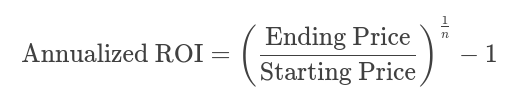

In [85]:
def ROI(ticker, years):
    stock_symbol = ticker  # Example: Apple Inc.
    start_date = "2020-01-01"

    end_date = f"{2020+years}-01-01"
    # Fetch historical data
    data = yf.download(stock_symbol, start=start_date, end=end_date)['Close']

    # Calculate ROI
    starting_price = data.iloc[0]  # First price in the dataset
    ending_price = data.iloc[-1]   # Last price in the dataset

    # Extract scalar values from the Series
    starting_price_scalar = starting_price.item()  # Convert to scalar
    ending_price_scalar = ending_price.item()      # Convert to scalar

    # Calculate ROI
    roi = ((ending_price_scalar - starting_price_scalar) / starting_price_scalar) * 100

    # Calculate annualized ROI
    years = (data.index[-1] - data.index[0]).days / 365.25  # Convert days to years
    annualized_roi = ((ending_price_scalar / starting_price_scalar) ** (1 / years) - 1) * 100

    # # Output results
    # print(f"Stock Symbol: {stock_symbol}")
    # print(f"Starting Price (2020-01-01): ${starting_price_scalar:.2f}")
    # print(f"Ending Price (2025-01-06): ${ending_price_scalar:.2f}")
    # print(f"Total ROI for {years} years: {roi:.2f}%")
    # print(f"Annualized ROI: {annualized_roi:.2f}%")

    return roi, annualized_roi

In [87]:
ROI('A',4)

[*********************100%***********************]  1 of 1 completed


(66.22889447127712, 13.586863973002883)